In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sn

In [10]:
plt.style.use('../config/paper_protein_content.mplstyle')

In [35]:
db_human = pd.read_excel('../data/hela/human_db.xlsx')

In [6]:
data_taras = pd.read_excel('../data/hepatocytes/prepared/hepatocyte_data_taras.xlsx')

In [7]:
data_taras.head()

,Entry,Mass,liver2,liver3
0,P07148,14208,227.914122,169429090.7
1,P00325,39855,431.407590,145385142.4
2,P08263,25631,127.180249,113321757.9
3,P31327,164939,343.984271,111613716.4
4,P62805,11367,299.618267,107812620.0


In [10]:
wisniewski2012 = data_taras[['Entry', 'liver3']].dropna()

In [12]:
wisniewski2012.to_excel('../data/hepatocytes/processed/wisniewski2016_processed.xlsx', index=False)

In [13]:
olander2020 = data_taras[['Entry', 'liver2']].dropna()

In [15]:
olander2020['liver2_copies_per_cell'] = olander2020['liver2'] * 602.3 * 600

In [17]:
olander2020['liver2_copies_per_cell'].sum() / 3400

2390906.0431358526

In [18]:
wisniewski2012['liver3'].sum() / 3400

2455355.3925597374

In [20]:
olander2020.drop('liver2', axis=1, inplace=True)

In [21]:
olander2020

,Entry,liver2_copies_per_cell
0,P07148,8.236361e+07
1,P00325,1.559021e+08
2,P08263,4.596040e+07
3,P31327,1.243090e+08
4,P62805,1.082760e+08
...,...,...
8186,Q9C0C7,1.963240e+02
8187,Q9BQT9,1.828380e+02
8188,Q9BXX0,1.796481e+02
8189,Q7Z2Y8,1.502488e+02


In [22]:
olander2020.to_excel('../data/hepatocytes/processed/olander2020_processed.xlsx', index=False)

In [2]:
articles_names = ['wisniewski2016', 'olander2020']
articles_data =  [pd.read_excel(f'../data/hepatocytes/processed/{i}_processed.xlsx') for i in articles_names]

In [3]:
[len(i) for i in articles_data]

[7501, 6117]

In [4]:
articles_data = [i.drop_duplicates('Entry') for i in articles_data]

In [5]:
[len(i) for i in articles_data]

[7501, 6117]

In [6]:
core_proteins = set.intersection(*[set(i['Entry'].tolist()) for i in articles_data])
len(core_proteins)

5427

In [7]:
cn_total = [i['C [Copies/cell]'].sum() for i in articles_data]
cn_total

[8348208334.703108, 8129080546.6619005]

In [8]:
cn_total_per_um = [i/2800 for i in cn_total]
cn_total_per_um

[2981502.9766796813, 2903243.05237925]

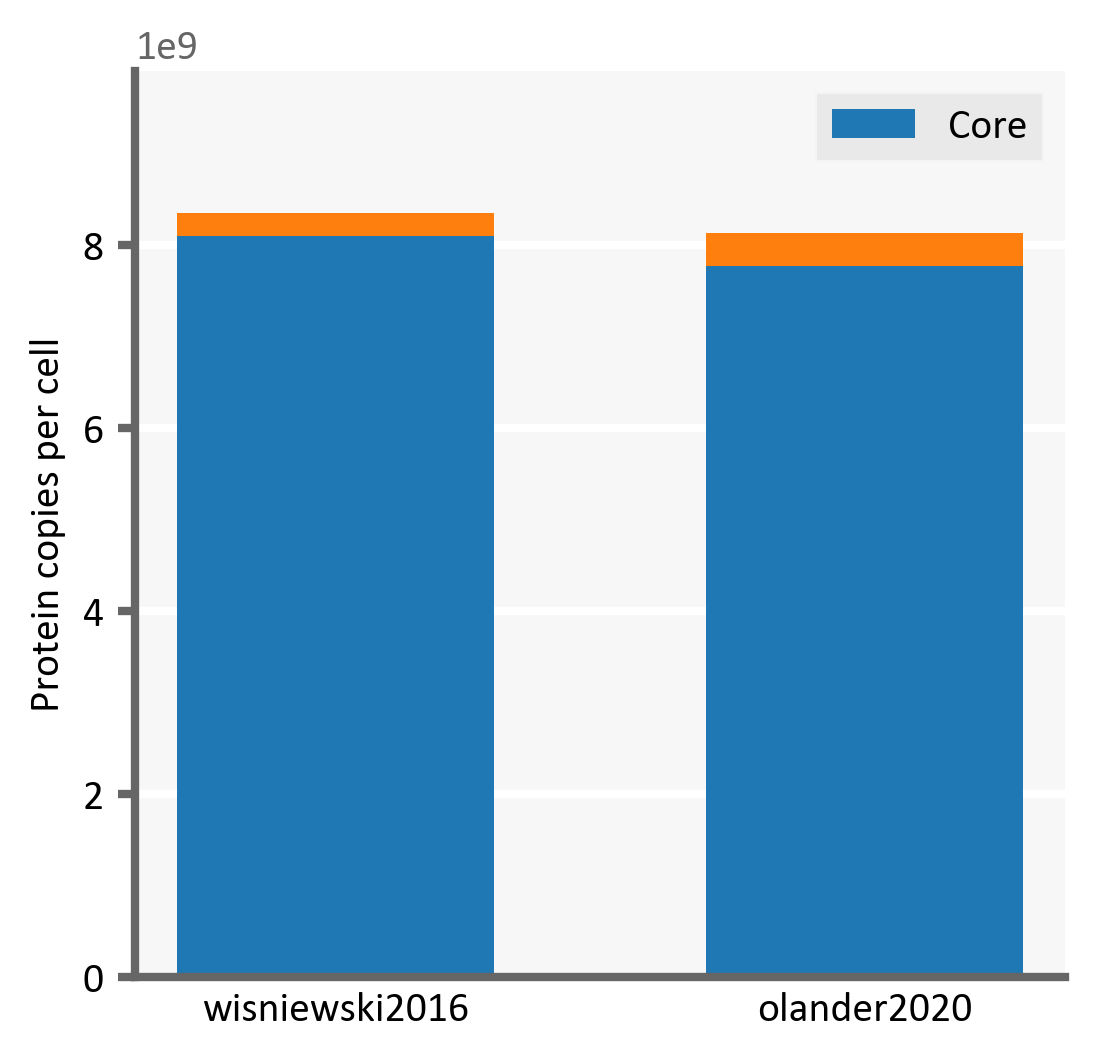

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set(xticks = range(len(articles_data)),
       xticklabels = articles_names,
       ylabel = 'Protein copies per cell',
       ylim = [0, 9.9e+9])

ax.bar(range(len(articles_data)), 
       height = [i['C [Copies/cell]'].sum() for i in articles_data], 
       color = 'C1',
       width = 0.6)

ax.bar(range(len(articles_data)), 
       height = [i[i['Entry'].isin(core_proteins)]['C [Copies/cell]'].sum() for i in articles_data], 
       color = 'C0',
       label = 'Core',
       width = 0.6)

ax.legend()

plt.savefig('../graphs/hepa_total_cn_with_core.png')

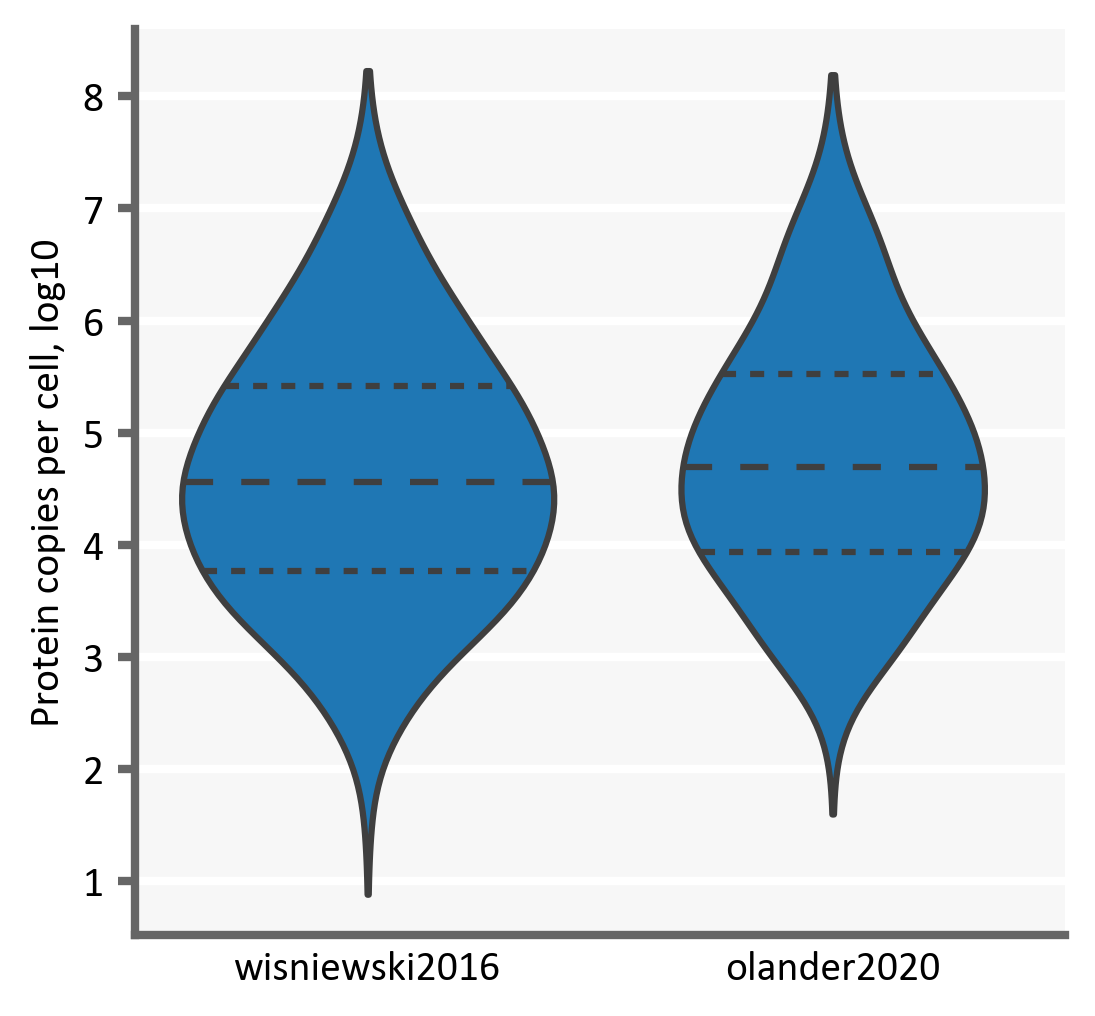

In [13]:
plt.figure(figsize=(4,4))

sn.violinplot(data = [np.log10(i['C [Copies/cell]'].to_numpy()) for i in articles_data],
              inner = 'quartiles',
              cut = 0, 
              scale = 'count', 
              bw = 0.3,
              color = 'C0',
              saturation = 1)

plt.ylabel('Protein copies per cell, log10')
plt.xticks(range(len(articles_names)), articles_names)

plt.savefig('../graphs/hepa_cn_dist_violin.png')

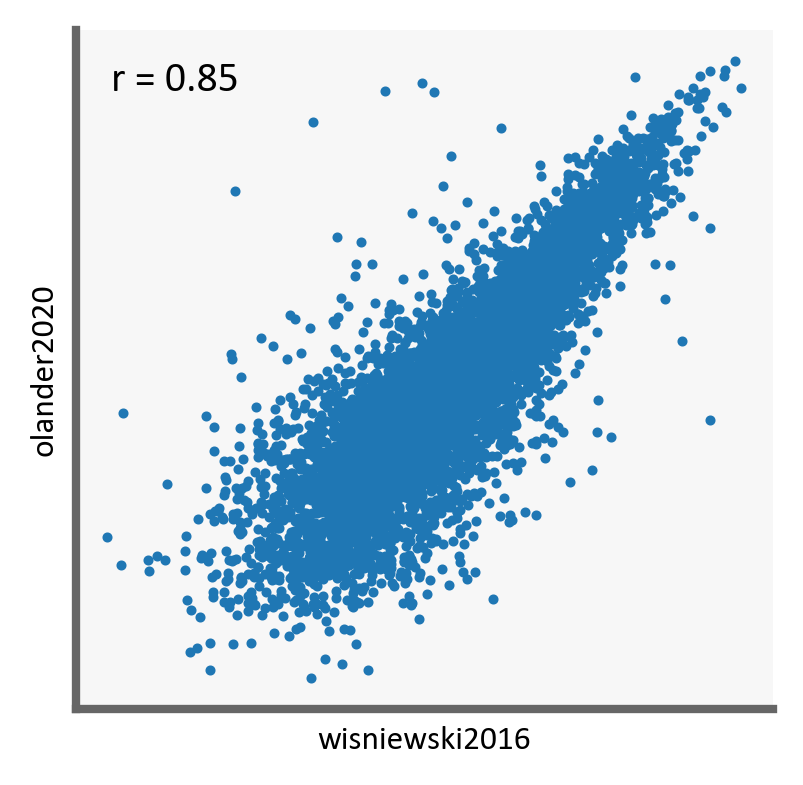

In [48]:
fig, ax = plt.subplots(figsize=(3,3))
inter = set.intersection(set(articles_data[0]['Entry']), set(articles_data[1]['Entry']))
d1 = np.log(articles_data[0][articles_data[0]['Entry'].isin(inter)].drop_duplicates('Entry').set_index('Entry')['C [Copies/cell]'])
d2 = np.log(articles_data[1][articles_data[1]['Entry'].isin(inter)].drop_duplicates('Entry').set_index('Entry')['C [Copies/cell]'])
dd = pd.concat([d1, d2], axis=1).dropna()
ax.set_xticks([])
ax.set_yticks([])
ax.scatter(dd.iloc[:,-2], dd.iloc[:,-1], s=2, color='C0')
ax.text(0.05, 0.91, 'r = {:.2f}'.format(round(pearsonr(dd.iloc[:,-2], dd.iloc[:,-1])[0],2)), transform = ax.transAxes)
ax.set_xlabel(articles_names[0], size=8)
ax.set_ylabel(articles_names[1], size=8)
            
plt.savefig('../graphs/hepa_correlations.png')

In [20]:
mass_avg = []
for i in articles_data:
    i['Mass'] = i['Entry'].map(db_human.set_index('Entry')['Mass'])
    mass_avg.append((i['C [Copies/cell]']*i['Mass']).sum()/i['C [Copies/cell]'].sum())
    
mass_avg

[41497.531631779006, 43697.499112298756]

In [21]:
mass_total = []
for i in articles_data:
    i['Mass'] = i['Entry'].map(db_human.set_index('Entry')['Mass'])
    mass_total.append((i['C [Copies/cell]']*i['Mass']).sum())
    
mass_total2 = [i*1.66054e-12 for i in mass_total]

mass_total

[346430039438023.4, 355220489971563.5]

In [22]:
mass_total2

[575.2609376884153, 589.85783241738]

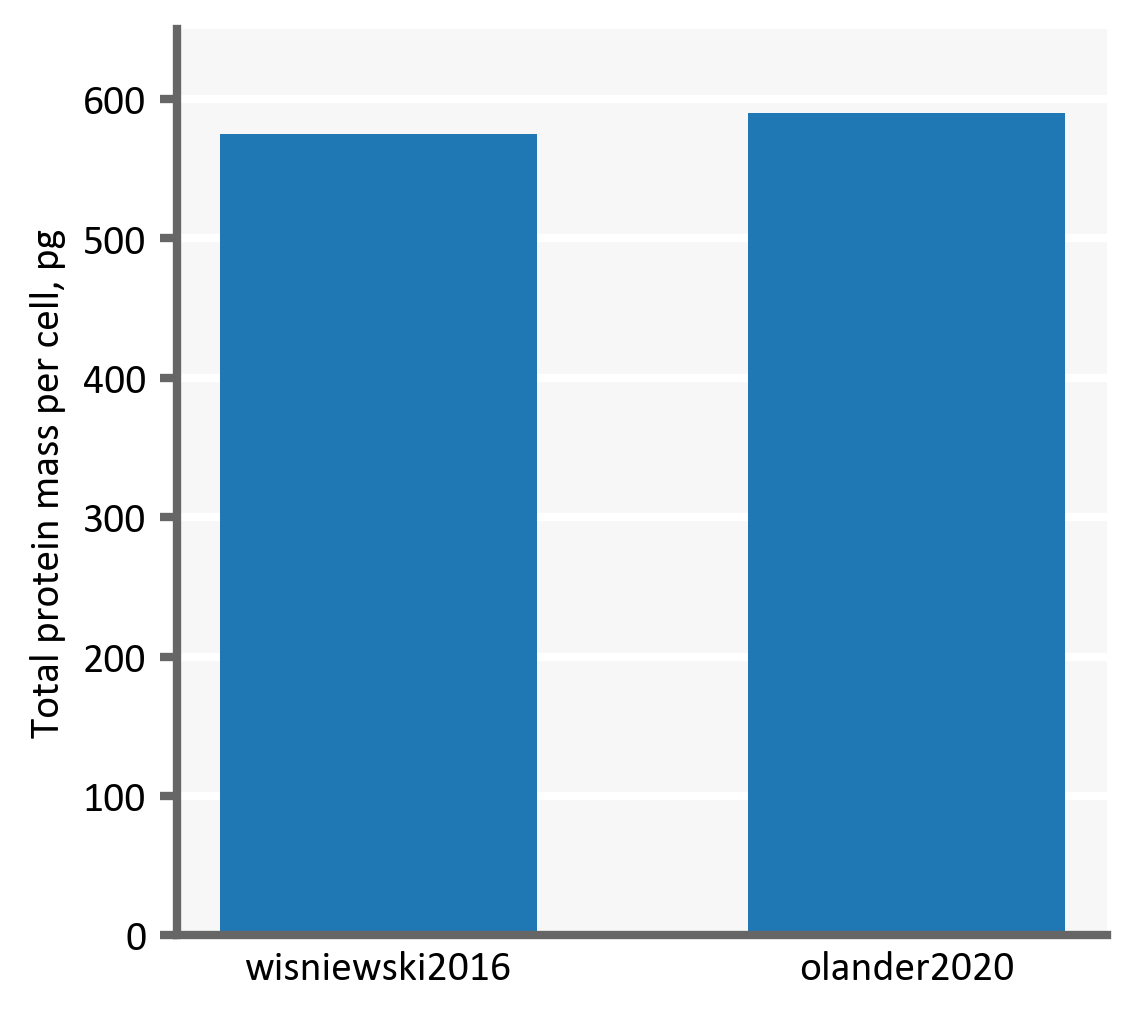

In [24]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set(xticks = range(len(articles_data)),
       xticklabels = articles_names,
       ylabel = 'Total protein mass per cell, pg',
       ylim = [0, 650])

ax.bar(range(len(articles_data)), 
       height = mass_total2, 
       color = 'C0',
       width = 0.6)

plt.savefig('../graphs/hepa_total_mass_per_cell.png')

In [27]:
milo = [0.176*6*10**11/i*2800 for i in mass_avg]
milo

[7125243077.676621, 6766519961.248313]

In [28]:
milo_per_um = [i/2800 for i in milo]
milo_per_um

[2544729.6705987933, 2416614.2718743975]

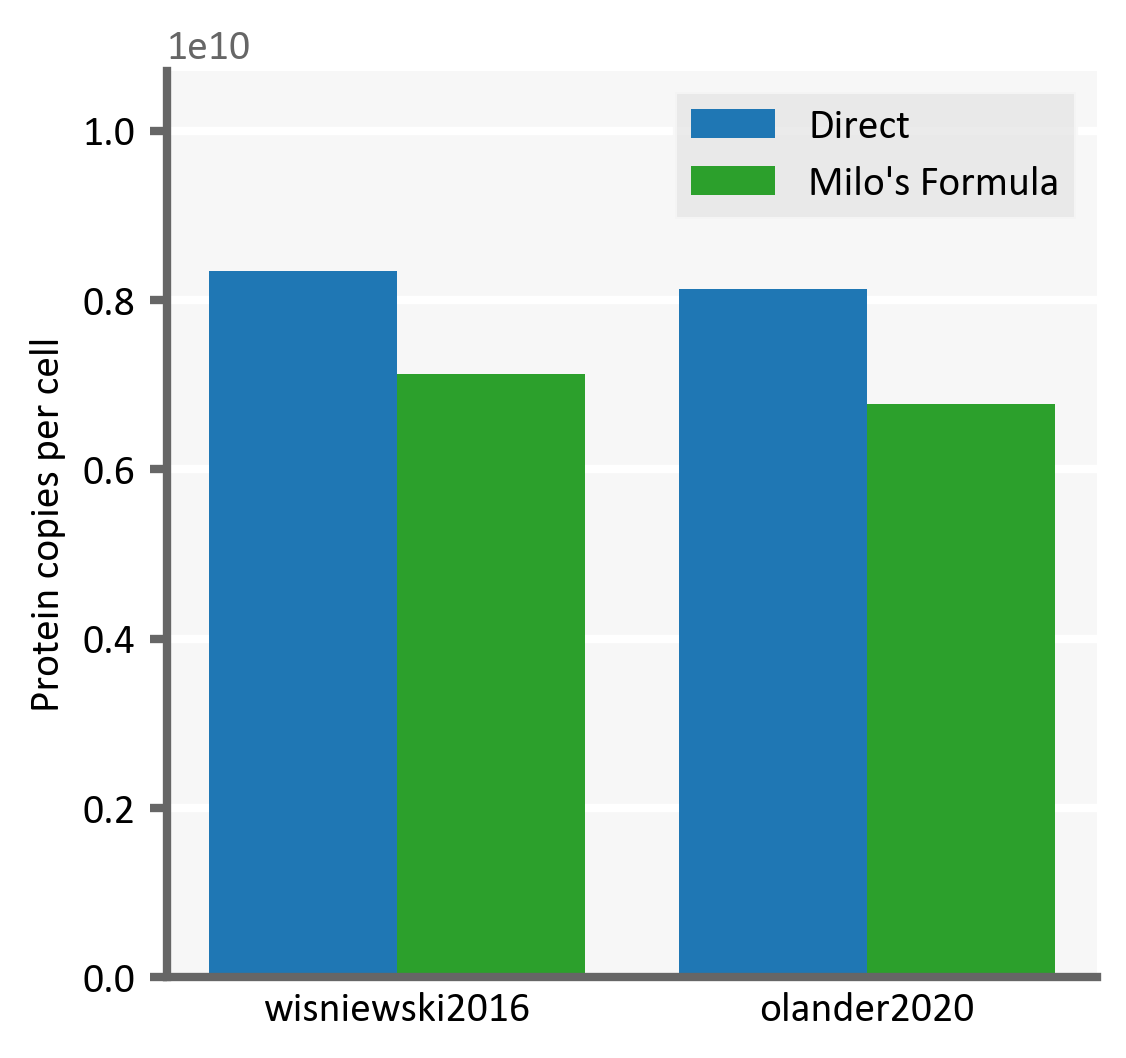

In [34]:
fig, ax = plt.subplots(figsize=(4,4))

ax.set(xticks = range(len(articles_data)),
       xticklabels = articles_names,
       ylabel = 'Protein copies per cell',
       ylim = [0, 10.7e+9])

ax.bar(np.linspace(0, len(articles_data)-1, 2)-0.2, 
       height = [i['C [Copies/cell]'].sum() for i in articles_data], 
       color = 'C0',
       width = 0.4,
       label = 'Direct')

ax.bar(np.linspace(0, len(articles_data)-1, 2)+0.2, 
       height = milo, 
       color = 'C2',
       width = 0.4,
       label = 'Milo\'s Formula')

ax.legend()

plt.savefig('../graphs/hepa_direct_vs_milo.png')

In [36]:
ribo_quants = [i[i['Entry'].isin(db_human[db_human['Ribosomal'] == True]['Entry'].to_list())]['C [Copies/cell]'].to_numpy() for i in articles_data]
ribo_quants = [i[i != 0.0] for i in ribo_quants]

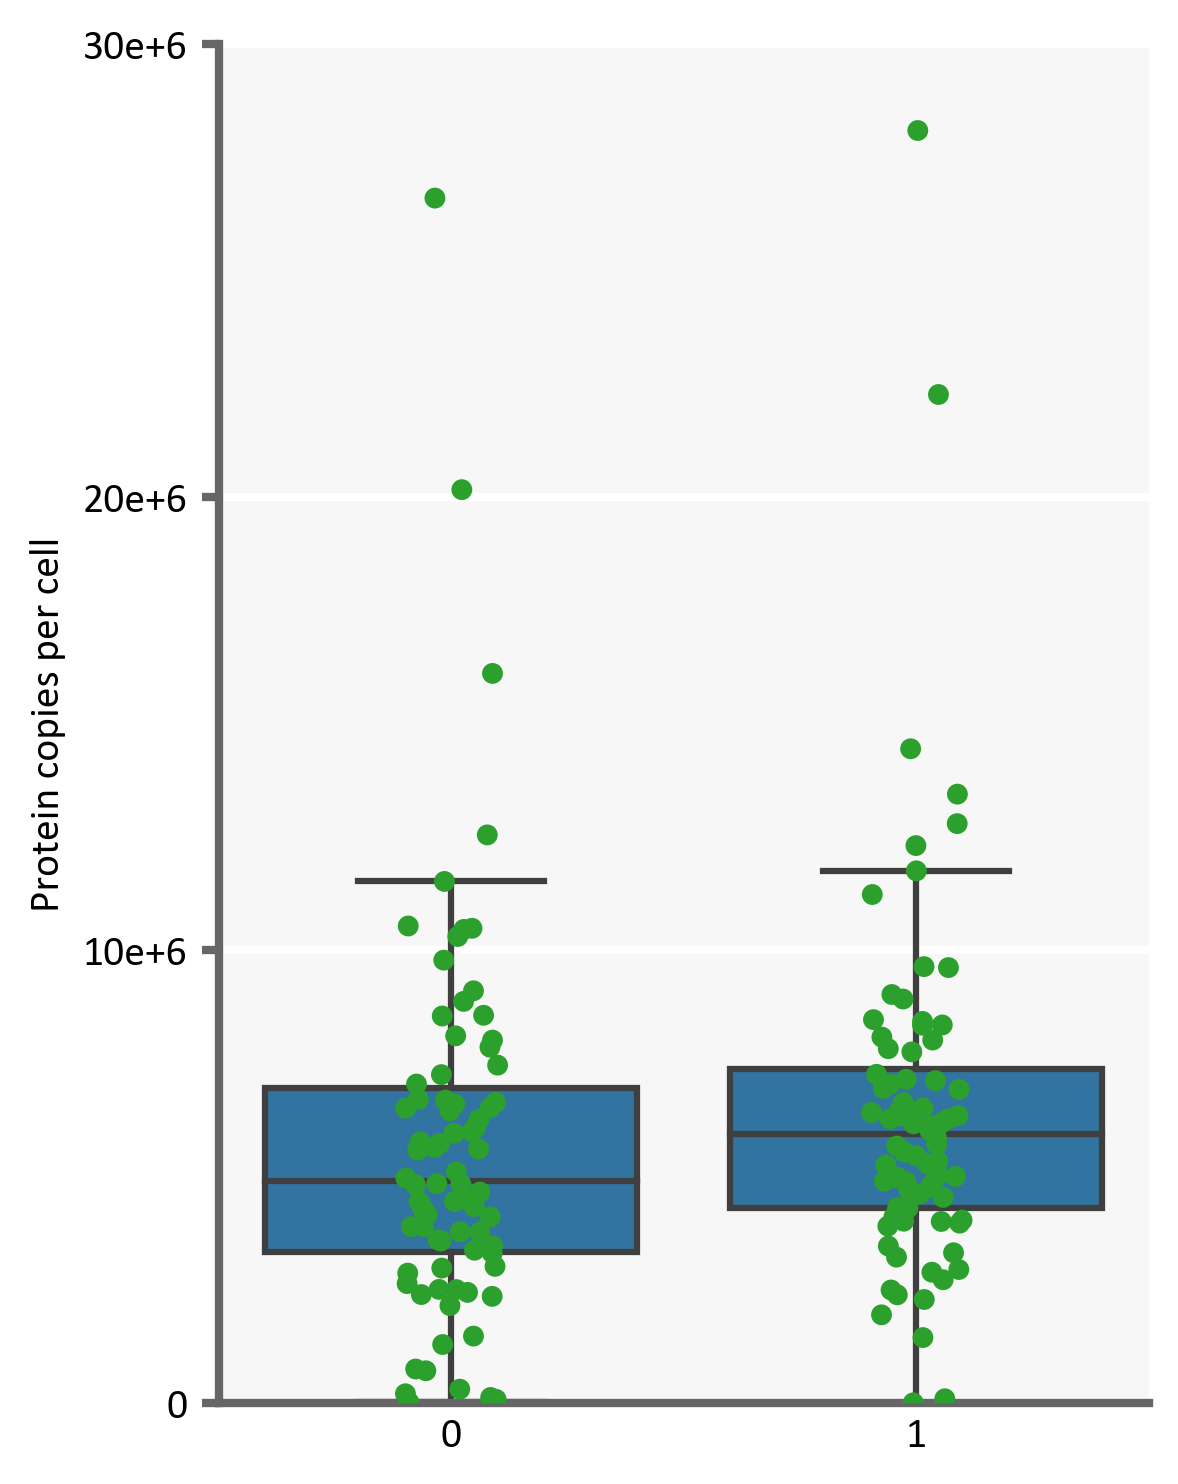

In [42]:
plt.figure(figsize=(4,6))
plt.ylabel('Protein copies per cell')
sn.boxplot(data=ribo_quants, color='C0', fliersize = 0)
sn.stripplot(data=ribo_quants, color='C2')
plt.ylim([0,3e+7])
plt.yticks([0, 10e+6, 20e+6, 30e+6], ['0', '10e+6', '20e+6', '30e+6'])
plt.savefig('../graphs/hepa_ribosomal_dist.png')

In [47]:
articles_data[0][articles_data[0]['Entry'].isin(db_human[db_human['Ribosomal']==True]['Entry'])].sort_values(by='C [Copies/cell]', ascending=False)

,Entry,C [Copies/cell],Mass
52,P62979,2.660769e+07,17965
82,P05387,2.017138e+07,11665
104,P62857,1.611483e+07,7841
139,P39019,1.255013e+07,16060
154,P23396,1.152262e+07,26688
...,...,...,...
1745,P62891,3.145847e+05,6407
2075,P22090,2.128925e+05,29456
2503,Q9UNX3,1.312284e+05,17256
2857,Q6DKI1,8.936200e+04,29669
